In [50]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, algebra
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import itertools
import time

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cholesky', 'identity', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [58]:
def doerfler_mark(x, theta=0.9, TOL=0.01):
    """Given an array of x, return a minimal array of indices such that the indexed
    values of x have norm of at least theta * norm(errors). Requires sorting the array x."""
    idx = np.argsort(x)
    n=len(idx)
    total = x@x
    S = 0
    for i in reversed(range(n)):
        S += x[idx[i]]**2
        if (S > theta * total):
            k=i-1
            while (abs(x[idx[i]]-x[idx[k]])/x[idx[i]] < TOL) and k>0:
                k-=1
            break
    return idx[k:]

In [187]:
def quick_mark(x, idx, l, u ,v):
    p = np.arange(l,u+1)[argmedian(x[idx[l:(u+1)]])]+l
    idx_new, g, s = Partition(x, idx, l, u , p)
    sigma = sum(x[idx_new[l:(g+1)]])
    if sigma >= v: return quick_mark(x,idx_new,l,g,v)
    elif sigma + (s-g-1)*x[idx[p]]: return idx_new, g+ceil((v-sigma)/x[idx[p]])
    else: return quick_mark(x, idx_new,s,u,v-sigma-(s-g-1)*x[idx[p]])
    return x

def Partition(x, idx, l, u, p):
    idx_new = np.argpartition(x[idx[l:(u+1)]],p)
    idx_equal = np.where(x[idx_new+l]==x[idx[p]])[0]
    return np.concatenate([idx[:l],idx_new+l,idx[(u+1):-1]]), p-1, p+1
    
def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2]

In [188]:
x=np.random.rand(9)

In [193]:
x[0:9]

array([0.195, 0.952, 0.984, 0.427, 0.117, 0.844, 0.947, 0.628, 0.730])

In [189]:
idx, n = quick_mark(x,np.arange(len(x)),0,len(x)-1,0.9*sum(x))
idx = idx[1:int(n)]

In [190]:
idx

array([1, 8, 3, 4, 5, 6, 7])

In [173]:
Partition(x,np.arange(len(x)),0,len(x)-1,argmedian(x))

(array([3, 8, 2, 0, 7, 1, 5, 6, 4]), array([4]), 7)

In [143]:
argmedian(x)

4

In [124]:
np.argpartition(x,argmedian(x))

array([1, 4, 5, 0, 7, 6, 8, 2, 3])

In [108]:
np.partition

<function numpy.partition(a, kth, axis=-1, kind='introselect', order=None)>

In [55]:
x[0:2]

array([3, 4])

In [68]:
N=int(1e7)
err = np.random.rand(N)

In [69]:
t=time.time()
idx = doerfler_mark(err)
print(time.time()-t)

4.012592554092407


In [65]:
x=np.random.rand(2**20)

In [80]:
maxiter=27
T = np.zeros(maxiter)
for i in range(maxiter):
    x=np.random.rand(2**i)
    t=time.time()
    idx = doerfler_mark(x)
    T[i] = time.time()-t
    print(T[i])

0.0006411075592041016
5.602836608886719e-05
2.4318695068359375e-05
3.4332275390625e-05
2.2172927856445312e-05
3.409385681152344e-05
0.00031757354736328125
0.0001533031463623047
0.0007352828979492188
0.0006155967712402344
0.0012314319610595703
0.002138853073120117
0.00421452522277832
0.0029239654541015625
0.005639076232910156
0.01613926887512207
0.03385114669799805
0.05999922752380371
0.09508347511291504
0.1924445629119873
0.4063246250152588
0.7614285945892334
1.607144832611084
3.309105396270752
6.980187892913818
14.503744840621948
30.11576795578003


In [81]:
T[10:][1:]/T[10:][:-(1)]

array([1.737, 1.970, 0.694, 1.929, 2.862, 2.097, 1.772, 1.585, 2.024, 2.111, 1.874, 2.111, 2.059, 2.109, 2.078, 2.076])

In [34]:
np.median(x)

0.4715836188756056

In [23]:
np.sqrt((err[idx]@err[idx])/(err@err))

0.9000000940735943

In [10]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]

kvs=[(bspline.make_knots(1,0.0,1.0,xN),bspline.make_knots(1,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      geometry.Quad(np.array([[0.,2.,1.,2.],
                              [1.,1.,2.,2.]])),
      geometry.Quad(np.array([[2.,3.,2.,3.5],
                              [1.,1.,2.,2.5]])),
      geometry.Quad(np.array([[2.,3.,3.,3.5],
                              [1.,0.,1.,0.5]])),
      geometry.Quad(np.array([[2.,2.5,2.,3.],
                              [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
M=topology.PatchMesh(patches)
M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

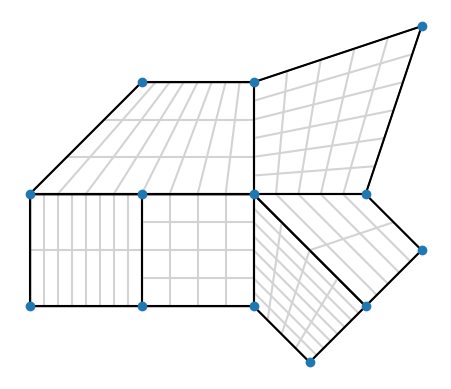

In [18]:
M.draw(knots=1, patch_idx=0, nodes=1, axis='off')
axis('scaled');

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)